# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR,OneCycleLR
from torchsummary import summary


In [2]:
from google.colab import files
# uploaded = files.upload()

In [3]:
import model
from model import Net

ModuleNotFoundError: ignored

# ALL 3 model params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(normalization_type="group").to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
         GroupNorm-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 15, 24, 24]           1,350
         GroupNorm-6           [-1, 15, 24, 24]              30
              ReLU-7           [-1, 15, 24, 24]               0
         Dropout2d-8           [-1, 15, 24, 24]               0
         MaxPool2d-9           [-1, 15, 12, 12]               0
           Conv2d-10           [-1, 15, 10, 10]           2,025
        GroupNorm-11           [-1, 15, 10, 10]              30
             ReLU-12           [-1, 15, 10, 10]               0
        Dropout2d-13           [-1, 15, 10, 10]               0
           Conv2d-14             [

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(normalization_type="layer").to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
         GroupNorm-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 15, 24, 24]           1,350
         GroupNorm-6           [-1, 15, 24, 24]              30
              ReLU-7           [-1, 15, 24, 24]               0
         Dropout2d-8           [-1, 15, 24, 24]               0
         MaxPool2d-9           [-1, 15, 12, 12]               0
           Conv2d-10           [-1, 15, 10, 10]           2,025
        GroupNorm-11           [-1, 15, 10, 10]              30
             ReLU-12           [-1, 15, 10, 10]               0
        Dropout2d-13           [-1, 15, 10, 10]               0
           Conv2d-14             [

In [13]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(normalization_type="batch").to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
       BatchNorm2d-6           [-1, 20, 24, 24]              40
              ReLU-7           [-1, 20, 24, 24]               0
         Dropout2d-8           [-1, 20, 24, 24]               0
         MaxPool2d-9           [-1, 20, 12, 12]               0
           Conv2d-10           [-1, 20, 10, 10]           3,600
      BatchNorm2d-11           [-1, 20, 10, 10]              40
             ReLU-12           [-1, 20, 10, 10]               0
        Dropout2d-13           [-1, 20, 10, 10]               0
           Conv2d-14             [

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def merge_conv_normalization(conv_layer,normalization_type):
    new_layer = torch.nn.Conv2d(
        conv_layer.in_channels,
        conv_layer.out_channels,
        kernel_size=conv_layer.kernel_size,
        stride=conv_layer.stride,
        padding=conv_layer.padding,
        bias=conv_layer.bias,
    )
    if normalization_type == "batch":
        nl = nn.BatchNorm2d(conv_layer.out_channels)
    elif normalization_type == "group":
        if conv_layer.out_channels%2==0:
            group = 2
        else:
            group=1
        nl = nn.GroupNorm(group, conv_layer.out_channels)
    elif normalization_type == "layer":
        nl = nn.GroupNorm(1, conv_layer.out_channels)

    return nn.Sequential(new_layer, nl)

class Net(nn.Module):
    def __init__(self, normalization_type):
        super(Net, self).__init__()
        # RF = 1
        self.normalization_type = normalization_type
        #Input Block
        self.convblock1 = nn.Sequential(
            merge_conv_normalization(
                nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=0, bias=False),   
                self.normalization_type
            ),
            nn.ReLU(),
            nn.Dropout2d(0.01)
        ) 
        # input_size = 28*28*1
        # output_size = 26*26*10
        # RF = 3

        self.convblock2 = nn.Sequential(
            merge_conv_normalization(
                nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=0, bias=False),
                self.normalization_type
            ),
            nn.ReLU(),
            # nn.BatchNorm2d(15),
            nn.Dropout2d(0.01)
        ) 
        # input_size = 26*26*10
        # output_size = 24*24*15
        # RF = 5
        
        # Transition block
        self.maxPool = nn.MaxPool2d(2,2)
        # input_size = 24*24*15
        # output_size =12*12*15
        # RF = 10

        self.convblock3 = nn.Sequential(
            merge_conv_normalization(
                nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, padding=0, bias=False),
                self.normalization_type
            ),
            nn.ReLU(),
            # nn.BatchNorm2d(20),
            nn.Dropout2d(0.01)
        )
        # input_size = 12*12*15
        # output_size =10*10*20
        # RF = 12

        self.convblock4 = nn.Sequential(
            merge_conv_normalization(
                nn.Conv2d(in_channels=20, out_channels=10, kernel_size=3, padding=0, bias=False),
                self.normalization_type
            ),
            nn.ReLU(),
            # nn.BatchNorm2d(15),
            nn.Dropout2d(0.01)
        )
        # input_size = 10*10*20
        # output_size = 8*8*15
        # RF = 14

        self.convblock5 = nn.Sequential(
        merge_conv_normalization(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0, bias=False),
            self.normalization_type
        ),
        nn.ReLU(),
            # nn.BatchNorm2d(15),
            nn.Dropout2d(0.01)
        )
        # input_size = 8*8*15
        # output_size = 6*6*15
        # RF = 16

        #Output Block
        self.gap = nn.AvgPool2d(6)
        # input_size = 6*6*15
        # output_size = 1*1*15
        # RF = 18


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=1, padding=0, bias=False)
        )
        # input_size = 1*1*15
        # output_size = 1*1*10
        # RF = 20


    def forward(self, x):
        
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.maxPool(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.gap(x)
        x = self.convblock6(x)
      
        x = x.reshape(-1,10)

        return F.log_softmax(x, dim=-1)


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [14]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                    #    transforms.ToPILImage(),
                                       transforms.RandomRotation((-7.5, 7.5), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [15]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [16]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(2.8017)
 - std: tensor(0.2500)
 - var: tensor(0.0625)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


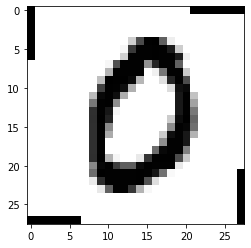

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

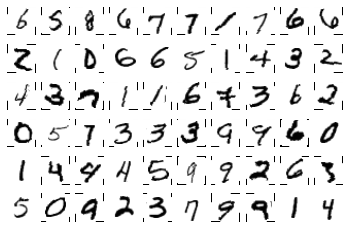

In [ ]:




figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [17]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch,flag):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    # train_losses.append(loss)
    # loss =  F.mse_loss(y_pred, target)
    if flag==True:
        # l1 = 0
        l1 = 0            
        for W in model.parameters():
            l1 = l1+W.abs().sum()
        loss = loss + lambda_l1 *l1
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [18]:
import matplotlib.pyplot as plt
def find_misclassified(test_loader, device):
        misclassified = []
        misclassified_prediction = []
        misclassified_target = []
        i=0
        # put the model to evaluation mode
        model.eval()
        # turn off gradients
        with torch.no_grad():
            for data, target in test_loader:
                # move them to the respective device
                data, target = data.to(device), target.to(device)
                # do inferencing
                output = model(data)
                # get the predicted output
                pred = output.argmax(dim=1, keepdim=True)

                # get the current misclassified in this batch
                list_misclassified = (pred.eq(target.view_as(pred)) == False)
                batch_misclassified = data[list_misclassified]
                batch_mis_prediction = pred[list_misclassified]
                batch_mis_target = target.view_as(pred)[list_misclassified]

                # batch_misclassified

                misclassified.append(batch_misclassified)
                misclassified_prediction.append(batch_mis_prediction)
                misclassified_target.append(batch_mis_target)
                i =i+1
                if i>=10:
                    break

        # group all the batched together
        misclassified = torch.cat(misclassified)
        misclassified_pred = torch.cat(misclassified_prediction)
        misclassified_target = torch.cat(misclassified_target)
        ncols=5
        image_data, predicted, actual=misclassified, misclassified_pred, misclassified_target
        fig, ax = plt.subplots(2,5,figsize=(8, 4))
        for i in range(2):
            for j in range(5):
                index = i * ncols + j 
                ax[i, j].axis("off")
                ax[i, j].set_title("  Predicted: %d\nActual: %d" % (predicted[index], actual[index]))
                ax[i, j].imshow(image_data[index].cpu().numpy(), cmap="gray_r")


# find_misclassified(test_loader, device)

# EPOCH

In [19]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

# will be used while plotting graphs
lambda_l1 =0.001
train_losses = []
test_losses = []
train_acc = []
test_acc = []

training_losses_group = []
testing_losses_group = []
training_accuracy_group = []
testing_accuracy_group = []

print(" B norm")
model = Net(normalization_type="batch").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(1, 21):
    print("EPOCH:", epoch)#, "LR = ", scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch,flag=True)
    test(model, device, test_loader)
    #scheduler.step()
# training_losses_group.append(train_losses)
# testing_losses_group.append(test_losses)
# training_accuracy_group.append(train_acc)
# testing_accuracy_group.append(test_acc)
b_train_losses = train_losses
b_test_losses = test_losses 
b_train_acc = train_acc
b_test_acc = test_acc
#find_misclassified(device, test_loader)

 B norm
EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.5668519139289856 Batch_id=468 Accuracy=76.56: 100%|██████████| 469/469 [00:45<00:00, 10.36it/s]



Test set: Average loss: 0.1800, Accuracy: 9624/10000 (96.24%)

EPOCH: 2


Loss=0.3745943605899811 Batch_id=468 Accuracy=95.08: 100%|██████████| 469/469 [00:45<00:00, 10.26it/s]



Test set: Average loss: 0.1036, Accuracy: 9749/10000 (97.49%)

EPOCH: 3


Loss=0.4294475317001343 Batch_id=468 Accuracy=95.56: 100%|██████████| 469/469 [00:46<00:00, 10.15it/s]



Test set: Average loss: 0.0814, Accuracy: 9790/10000 (97.90%)

EPOCH: 4


Loss=0.5517058372497559 Batch_id=468 Accuracy=95.82: 100%|██████████| 469/469 [00:46<00:00, 10.13it/s]



Test set: Average loss: 0.0938, Accuracy: 9765/10000 (97.65%)

EPOCH: 5


Loss=0.36390480399131775 Batch_id=468 Accuracy=95.87: 100%|██████████| 469/469 [00:46<00:00, 10.15it/s]



Test set: Average loss: 0.0868, Accuracy: 9772/10000 (97.72%)

EPOCH: 6


Loss=0.37523624300956726 Batch_id=468 Accuracy=95.96: 100%|██████████| 469/469 [00:46<00:00, 10.16it/s]



Test set: Average loss: 0.1106, Accuracy: 9668/10000 (96.68%)

EPOCH: 7


Loss=0.3108280897140503 Batch_id=468 Accuracy=96.03: 100%|██████████| 469/469 [00:46<00:00, 10.13it/s]



Test set: Average loss: 0.0623, Accuracy: 9843/10000 (98.43%)

EPOCH: 8


Loss=0.354765921831131 Batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:46<00:00, 10.12it/s]



Test set: Average loss: 0.1023, Accuracy: 9703/10000 (97.03%)

EPOCH: 9


Loss=0.41812199354171753 Batch_id=468 Accuracy=96.33: 100%|██████████| 469/469 [00:46<00:00, 10.12it/s]



Test set: Average loss: 0.0655, Accuracy: 9821/10000 (98.21%)

EPOCH: 10


Loss=0.2756251096725464 Batch_id=468 Accuracy=96.31: 100%|██████████| 469/469 [00:46<00:00, 10.10it/s]



Test set: Average loss: 0.0787, Accuracy: 9780/10000 (97.80%)

EPOCH: 11


Loss=0.3571271300315857 Batch_id=468 Accuracy=96.26: 100%|██████████| 469/469 [00:46<00:00, 10.15it/s]



Test set: Average loss: 0.0760, Accuracy: 9768/10000 (97.68%)

EPOCH: 12


Loss=0.2937484085559845 Batch_id=468 Accuracy=96.33: 100%|██████████| 469/469 [00:46<00:00, 10.06it/s]



Test set: Average loss: 0.0861, Accuracy: 9752/10000 (97.52%)

EPOCH: 13


Loss=0.41205093264579773 Batch_id=468 Accuracy=96.25: 100%|██████████| 469/469 [00:46<00:00, 10.11it/s]



Test set: Average loss: 0.0600, Accuracy: 9836/10000 (98.36%)

EPOCH: 14


Loss=0.2801012694835663 Batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:46<00:00, 10.10it/s]



Test set: Average loss: 0.0954, Accuracy: 9754/10000 (97.54%)

EPOCH: 15


Loss=0.3079458773136139 Batch_id=468 Accuracy=96.31: 100%|██████████| 469/469 [00:46<00:00, 10.06it/s]



Test set: Average loss: 0.0905, Accuracy: 9741/10000 (97.41%)

EPOCH: 16


Loss=0.24386556446552277 Batch_id=468 Accuracy=96.37: 100%|██████████| 469/469 [00:46<00:00, 10.13it/s]



Test set: Average loss: 0.0784, Accuracy: 9772/10000 (97.72%)

EPOCH: 17


Loss=0.35397621989250183 Batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:46<00:00, 10.07it/s]



Test set: Average loss: 0.0766, Accuracy: 9759/10000 (97.59%)

EPOCH: 18


Loss=0.36619818210601807 Batch_id=468 Accuracy=96.41: 100%|██████████| 469/469 [00:46<00:00, 10.10it/s]



Test set: Average loss: 0.0958, Accuracy: 9712/10000 (97.12%)

EPOCH: 19


Loss=0.31671780347824097 Batch_id=468 Accuracy=96.42: 100%|██████████| 469/469 [00:46<00:00, 10.09it/s]



Test set: Average loss: 0.0848, Accuracy: 9774/10000 (97.74%)

EPOCH: 20


Loss=0.32237985730171204 Batch_id=468 Accuracy=96.30: 100%|██████████| 469/469 [00:46<00:00, 10.07it/s]



Test set: Average loss: 0.0774, Accuracy: 9748/10000 (97.48%)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


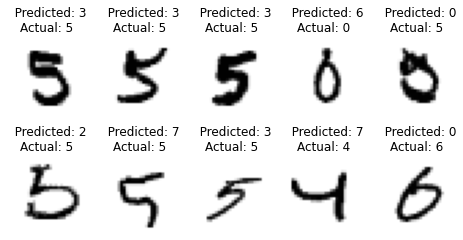

In [ ]:

find_misclassified(test_loader, device)

In [ ]:
model = Net(normalization_type="layer").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(1, 21):
    print("EPOCH:", epoch, "LR = ", scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch,flag=False)
    test(model, device, test_loader)
    scheduler.step()
# training_losses_group.append(train_losses)
# testing_losses_group.append(test_losses)
# training_accuracy_group.append(train_acc)
# testing_accuracy_group.append(test_acc)
    # find_misclassified(test_loader,device)
l_train_losses = train_losses
l_test_losses = test_losses 
l_train_acc = train_acc
l_test_acc = test_acc




/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


EPOCH: 1 LR =  [0.01]


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.4318279027938843 Batch_id=468 Accuracy=68.87: 100%|██████████| 469/469 [00:45<00:00, 10.34it/s]



Test set: Average loss: 0.2692, Accuracy: 9327/10000 (93.27%)

EPOCH: 2 LR =  [0.01]


Loss=0.19615115225315094 Batch_id=468 Accuracy=92.60: 100%|██████████| 469/469 [00:45<00:00, 10.40it/s]



Test set: Average loss: 0.0950, Accuracy: 9775/10000 (97.75%)

EPOCH: 3 LR =  [0.01]


Loss=0.1259990930557251 Batch_id=468 Accuracy=94.72: 100%|██████████| 469/469 [00:44<00:00, 10.49it/s]



Test set: Average loss: 0.0834, Accuracy: 9795/10000 (97.95%)

EPOCH: 4 LR =  [0.01]


Loss=0.18191082775592804 Batch_id=468 Accuracy=95.62: 100%|██████████| 469/469 [00:44<00:00, 10.43it/s]



Test set: Average loss: 0.0728, Accuracy: 9804/10000 (98.04%)

EPOCH: 5 LR =  [0.01]


Loss=0.07696100324392319 Batch_id=468 Accuracy=96.16: 100%|██████████| 469/469 [00:44<00:00, 10.54it/s]



Test set: Average loss: 0.0528, Accuracy: 9858/10000 (98.58%)

EPOCH: 6 LR =  [0.01]


Loss=0.15462245047092438 Batch_id=468 Accuracy=96.35: 100%|██████████| 469/469 [00:44<00:00, 10.62it/s]



Test set: Average loss: 0.0444, Accuracy: 9877/10000 (98.77%)

EPOCH: 7 LR =  [0.0001]


Loss=0.11893850564956665 Batch_id=107 Accuracy=96.76:  23%|██▎       | 106/469 [00:10<00:31, 11.51it/s] 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


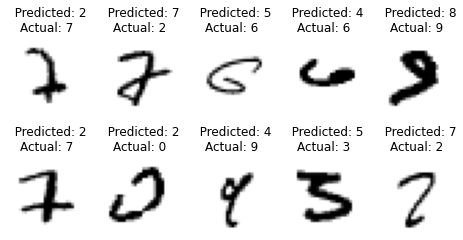

In [ ]:
find_misclassified(test_loader, device)

In [ ]:
model = Net(normalization_type="group").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
for epoch in range(1, 21):
    print("EPOCH:", epoch, "LR = ", scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch,flag=False)
    test(model, device, test_loader)
    scheduler.step()
g_train_losses = train_losses
g_test_losses = test_losses 
g_train_acc = train_acc
g_test_acc = test_acc
# training_losses_group.append(train_losses)
# testing_losses_group.append(test_losses)
# training_accuracy_group.append(train_acc)
# testing_accuracy_group.append(test_acc)
    # find_misclassified(test_loader,device)




/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


EPOCH: 1 LR =  [0.01]


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.19730709493160248 Batch_id=468 Accuracy=75.10: 100%|██████████| 469/469 [00:46<00:00, 10.07it/s]



Test set: Average loss: 0.1800, Accuracy: 9520/10000 (95.20%)

EPOCH: 2 LR =  [0.01]


Loss=0.05948668345808983 Batch_id=468 Accuracy=95.57: 100%|██████████| 469/469 [00:46<00:00, 10.06it/s]



Test set: Average loss: 0.0732, Accuracy: 9801/10000 (98.01%)

EPOCH: 3 LR =  [0.01]


Loss=0.10125979036092758 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:46<00:00, 10.13it/s]



Test set: Average loss: 0.0697, Accuracy: 9804/10000 (98.04%)

EPOCH: 4 LR =  [0.01]


Loss=0.043784260749816895 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:46<00:00, 10.08it/s]



Test set: Average loss: 0.0468, Accuracy: 9871/10000 (98.71%)

EPOCH: 5 LR =  [0.01]


Loss=0.02791815996170044 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:46<00:00, 10.14it/s]



Test set: Average loss: 0.0375, Accuracy: 9894/10000 (98.94%)

EPOCH: 6 LR =  [0.01]


Loss=0.07229465246200562 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:46<00:00, 10.02it/s]



Test set: Average loss: 0.0319, Accuracy: 9902/10000 (99.02%)

EPOCH: 7 LR =  [0.0001]


Loss=0.11151447892189026 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:46<00:00, 10.06it/s]



Test set: Average loss: 0.0271, Accuracy: 9924/10000 (99.24%)

EPOCH: 8 LR =  [0.001]


Loss=0.05330980196595192 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:46<00:00, 10.06it/s]



Test set: Average loss: 0.0273, Accuracy: 9930/10000 (99.30%)

EPOCH: 9 LR =  [0.001]


Loss=0.0755787119269371 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:46<00:00, 10.08it/s]



Test set: Average loss: 0.0272, Accuracy: 9929/10000 (99.29%)

EPOCH: 10 LR =  [0.001]


Loss=0.07338488847017288 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:46<00:00, 10.08it/s]



Test set: Average loss: 0.0263, Accuracy: 9934/10000 (99.34%)

EPOCH: 11 LR =  [0.001]


Loss=0.07380104809999466 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:46<00:00, 10.02it/s]



Test set: Average loss: 0.0263, Accuracy: 9926/10000 (99.26%)

EPOCH: 12 LR =  [0.001]


Loss=0.011877380311489105 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:46<00:00,  9.98it/s]



Test set: Average loss: 0.0256, Accuracy: 9934/10000 (99.34%)

EPOCH: 13 LR =  [1e-05]


Loss=0.11365091800689697 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:46<00:00, 10.04it/s]



Test set: Average loss: 0.0255, Accuracy: 9934/10000 (99.34%)

EPOCH: 14 LR =  [0.0001]


Loss=0.027082659304142 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:46<00:00, 10.06it/s]



Test set: Average loss: 0.0252, Accuracy: 9933/10000 (99.33%)

EPOCH: 15 LR =  [0.0001]


Loss=0.03693696856498718 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:46<00:00, 10.01it/s]



Test set: Average loss: 0.0253, Accuracy: 9935/10000 (99.35%)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


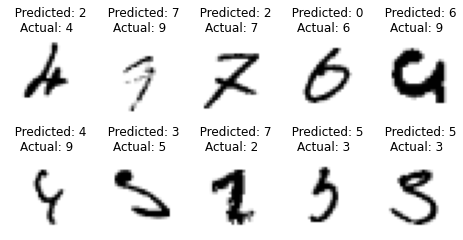

In [ ]:
find_misclassified(test_loader, device)

# Let's Train and test our model

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
ax1 = ax[0]
ax1.set_title("Loss")
ax1.plot(l_test_losses, color="blue", label="LN Test Loss")
ax1.plot(b_test_losses, color="red", label="BN Test Loss")
ax1.plot(b_test_losses,color="yellow", label="GN Test Loss")
ax1.legend()
ax2 = ax[1]
ax2.set_title("Accuracy")
ax2.plot(l_test_acc, color="pink", label="LN Test Accuracy")
ax2.plot(b_test_acc, color="maroon", label="BN Test Accuracy")
x2.plot(g_test_acc, color="purple", label="GN Test Accuracy")
ax2.legend()

plt.show()